## Customer Segmentation Using Unsupervised Machine Learning

In this project, we explore customer segmentation using unsupervised machine learning techniques to better understand customer behavior and purchasing patterns. The goal is to group customers into meaningful segments based on demographic information, spending behavior, and campaign interactions, without relying on predefined labels.

We begin with data preprocessing, where we handle categorical variables, scale numerical features, and prepare the dataset for analysis. To reduce dimensionality while preserving important information, we apply Principal Component Analysis (PCA) and visualize the data in a three-dimensional space.

Next, we use clustering techniques to identify distinct customer groups. The optimal number of clusters is determined using the elbow method, after which we apply agglomerative clustering to form the final segments. Once the clusters are created, we analyze and profile them by examining spending patterns, income levels, household characteristics, and promotional engagement.

This analysis helps uncover actionable insights that can support data-driven marketing strategies, customer targeting, and business decision-making.

In [2]:
#importing the Libraries

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [7]:
#loading the dataset

data = pd.read_csv('marketing_campaign.csv', sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [9]:
#information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Customer Segmentation - Practical Note**

Customer segmentation is a common and very useful project in data analysis. Most companies collect a large amount of data about their customers, and this data can be used in many meaningful ways.

One practical use is grouping customers based on shared characteristics such as age, gender, behavior, or purchasing patterns. These groups help businesses understand who their main customers are and how they behave.

For example, suppose customer data shows that the core buyers of a product are males around 40 years old. With this insight, the company can design marketing campaigns or promotions that directly target this specific group. This makes marketing efforts more focused and effective.

Without customer segmentation, companies often run broad campaigns aimed at everyone. This usually leads to high costs and low returns because the message is not relevant to most people. In short, customer segmentation helps businesses reduce wasted spending and make smarter, data-driven marketing decisions.

In [13]:
#to remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


We are recreating the `dt_customer` column by taking the original date-time values and converting them into dates. This makes the column easier to work with later, especially for analysis and feature creation.

Beyond just knowing the date when someone became a customer, we want to extract more useful information from this column. One important feature is how long a person has been a customer, which can be very valuable for later analysis and segmentation.

To do this, we first create a list of all customer enrollment dates by looping through the `dt_customer` column and storing each date in the list. Once this is done, we identify the newest customer enrollment date and the oldest customer enrollment date in the dataset.

The reason for finding the newest date is that we want to calculate how long each person has been a customer relative to the dataset, not relative to today’s date. Using today’s date could be misleading because the data was collected only up to a certain point in time. Therefore, we assume that the latest enrollment date represents the final data collection point.

Using this latest date, we calculate the customer duration in days for each individual. This gives a consistent and meaningful measure of how long each person has been a customer within the context of the dataset.

In [16]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

#dates of the newest and oldest recorded customer
print("The newest customer's enrollment date in the records:",max(dates))
print("The oldest customer's enrollment date in the records:",min(dates))

The newest customer's enrollment date in the records: 2014-06-29
The oldest customer's enrollment date in the records: 2012-07-30


We want to create a new column called `Customer_For`. Since we already created a list of customer enrollment dates, we first take the maximum value from that list. This maximum date represents the latest enrollment date in the dataset, and we store it as `d1`.

Next, we loop through all the dates in the list and calculate the difference between `d1` (the latest date) and each individual customer’s enrollment date. This difference gives us the number of days each person has been a customer relative to the dataset. We store all of these values in another list called `days`.

After that, we create a new column named `Customer_For` and assign it the values from the `days` list. This column represents the customer duration in days. Finally, we ensure that the `Customer_For` column is stored as numeric data so it can be used properly in calculations and modeling later on.

In [19]:
#created a feature "Customer_For"

days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

**Exploring Categorical Features**

We also want to examine the categorical information in the dataset. Categorical features include attributes such as marital status and education, which describe customer characteristics rather than numeric values.

To start, we focus on the `Marital_Status` feature. We run a count of the total categories to see what unique values exist in this column. This helps us understand the different marital status groups present in the data.

Next, we do the same for the `Education` feature. In addition to identifying the unique values, we also want to understand how frequently each category appears in the dataset. For this reason, we use a value count.

Looking at both the categories and their frequencies helps us understand how customers are distributed across these groups, which is useful for analysis and segmentation later on.

In [22]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


From the results, I can see that the majority of customers fall under the *Married* category in marital status. After that, the most common categories are *Together* and *Single*, followed by a few smaller groups. One interesting category is *YOLO* (you only live once), which stands out as a less common but unique entry in the data.

For the education feature, most customers have a *Graduation* level of education. This is followed by *PhD* and *Master*, along with a few other less frequent education levels. These observations give a quick snapshot of the customer profile and help set the context for further segmentation and analysis.

**Feature Engineering**

Next, we will perform a step in machine learning called *feature engineering*. This simply means creating additional columns that are different from the original ones in the dataset. In short, feature engineering prepares the dataset by reshaping it in a way that improves the quality and effectiveness of the model later on.

The goal is not to add random information, but to reorganize and transform the existing data into a format that will be more useful for a machine learning model. These new features help highlight important patterns and make the data easier for the model to learn from.

In [26]:
#Feature Engineering


#age of customer today
data["Age"] = 2025-data["Year_Birth"]

#total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#deriving living situation by marital status "Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#feature for total members in the household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#for clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

This dataset actually comes from a grocery store, so in addition to customer information, it includes how much customers spend on different product categories such as wine, fruits, meat, fish, sweets, and others.

First, we perform feature engineering on spending behavior. We create a new column called `Spent`, which represents the total amount a customer has spent. This value is calculated by summing all the individual spending columns across product categories. The goal is to capture overall purchasing behavior in a single feature.

Next, we create a column called `Living_With` to understand whether a customer lives alone or with someone else. This feature is derived from marital status. If the marital status is *Married* or *Together*, we label the customer as living with a partner. For categories such as *Single*, *Divorced*, *Widow*, *YOLO*, or other similar values, we assume the customer is living alone. This is a good example of creating a new feature using existing information.

After that, we create a column for the number of children in the household. This is done by summing the existing `Kidhome` and `Teenhome` values. This gives a single feature that represents how many children live with the customer.

Using the `Living_With` and children information, we then create a new column called `Family_Size`. If a customer lives alone, the base family size is 1. If they live with a partner, the base size is 2. To this, we add the number of children to get the total family size.

Once the children feature exists, I also create a binary feature called `Is_Parent`. If the number of children is greater than zero, this value is set to 1 (yes). Otherwise, it is set to 0 (no). This helps clearly separate parents from non-parents.

We also clean up the `Education` column by grouping values into broader categories. Education levels are simplified into *Undergraduate*, *Graduate*, and *Postgraduate*, where *Master* and *PhD* are grouped under postgraduate. This reduces noise and makes the feature more useful for modeling.

Finally, we clean the column names for spending categories by removing unnecessary prefixes such as `Mnt`, so the names become simpler, like *Wines* and *Fruits*. We also drop some columns that are not relevant to this project. These columns could be useful in an extended version of the analysis, but for now, removing them keeps the dataset focused and easier to work with.

In [29]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,56.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,29.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,48.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,55.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,66.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,132.000000,2525.000000,3.000000,5.000000,1.000000


At this point, I can already notice some unusual values in the dataset. For example, the maximum age shown is 132, which is clearly unrealistic. This suggests that there may be data quality issues that need to be addressed.

Because of this, the next step is to further clean the data. To better understand where these inaccuracies exist, we plan to use plots and visualizations. Visual analysis helps quickly **highlight outliers and values** that do not make sense, making it easier to decide what needs to be corrected or removed from the dataset.

Using visualizations at this stage ensures the data is reliable before moving forward with modeling or segmentation.


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

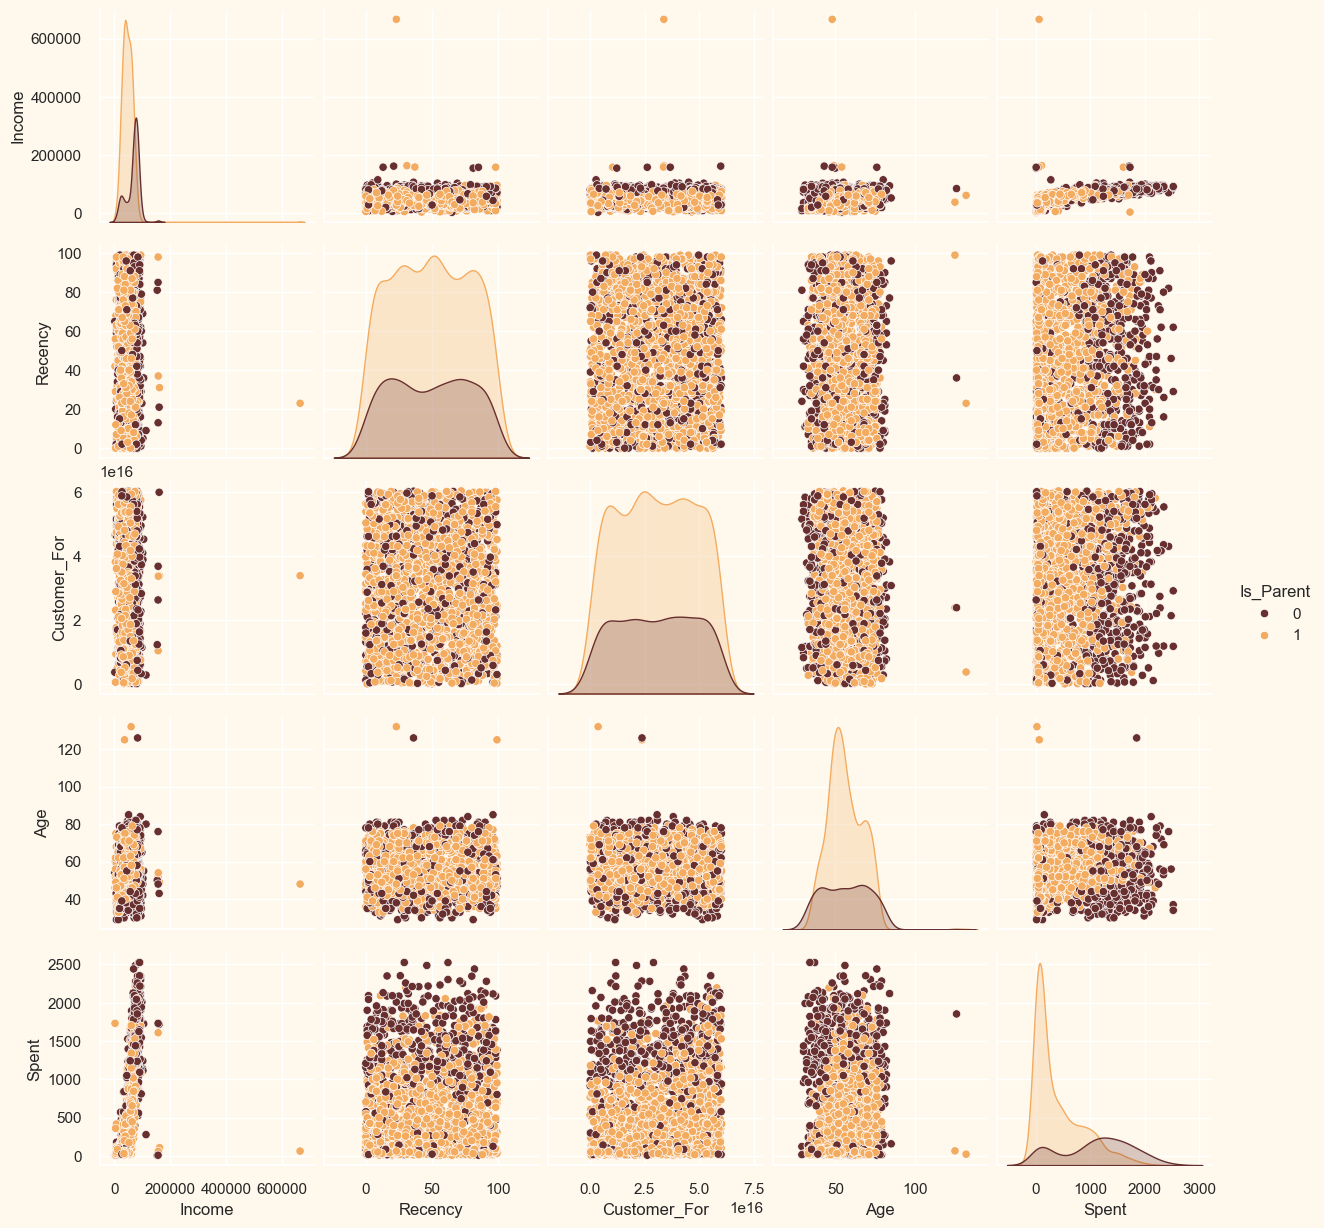

In [32]:
#to plot some selected features (pair plot visualization)

#setting up colors preferences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))

plt.show()

**Outliers Identified from the Pair Plot**

The visualization clearly highlights several outliers in the dataset. For **Age**, most customers fall within a reasonable range, but a few values appear above 120, which are unrealistic and indicate data errors that need to be cleaned.

For **Income**, most observations are concentrated in a low to mid range, while a small number of customers show extremely high income values. These outliers stretch the scale and compress the rest of the data, which can distort analysis and modeling if left untreated.

A similar pattern appears in **Spent**. Most customers spend relatively small amounts, but a few customers have very high spending values. These high spenders create a **right-skewed distribution and should be reviewed separately or handled using appropriate outlier treatment methods**.

Overall, the plots confirm the presence of unrealistic and extreme values that must be addressed before moving forward with segmentation or machine learning models.

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

To handle the outliers identified earlier, we apply caps to both age and income. In this step, we remove any records where the age is greater than 90, since values above this are unrealistic in the context of this dataset.

I also drop customers with an income higher than 600,000. These extreme income values are rare and distort the overall distribution, which can negatively affect analysis and modeling. These thresholds are manually chosen and hard-coded based on visual inspection and domain judgment. Applying these caps helps clean the data and makes the dataset more reliable for further analysis and customer segmentation.

In [38]:
#dropping the outliers by setting a cap on Age and income

data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]

print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   int64 

**Preparing Data for Machine Learning**

At this stage, the data exploration and data cleaning process is complete, so the focus can move to tasks related to machine learning. Before applying any models, the data must be pre-processed to make it suitable for machine learning algorithms.

The first step in preprocessing is handling categorical variables. In machine learning, categorical values need to be transformed into numerical values so that customer information can still be used effectively by the model.

In this dataset, categorical variables are identified by the `object` data type. Examples include features such as `Education` and `Living_With`. Most of the other columns are already numerical and do not require transformation. To identify all categorical variables, the object data types are selected from the dataset. This provides a clear list of features that need to be encoded before moving forward with model training.

In [43]:
#get list of categorical variables

s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


We use a technique called *label encoding* to transform categorical values into numerical form. Label encoding means assigning a numeric value to each category. For example, if a feature contains the categories *gold*, *silver*, and *bronze*, we can encode them as 0, 1, and 2 respectively. These numbers act only as identifiers and do not carry inherent meaning.

In this step, we create a label encoder and apply it to the dataset. We loop through each column with the `object` data type, since those columns contain the categorical values that need to be transformed.

We then replace each categorical column with integer codes, converting every unique string value into a numeric label. After this process, all features in the dataset become numerical, which makes the data suitable for machine learning algorithms.Finally, we print a confirmation message to ensure that all features have been successfully converted to numerical values.

In [46]:
#label Encoding the object dtypes

LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int32  
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   int64 

**Feature Scaling**

The next step, which is extremely important in machine learning, is *scaling*. Now that all features are numerical, it is necessary to ensure that the values are on a similar scale before training a model.

Scaling is important because different features can have very different ranges. For example, age may range roughly from 0 to 100, while income can reach tens or even hundreds of thousands. If these values are used as they are, features with larger numbers may dominate the model, even if they are not more important.

To address this, scaling is applied so that all features contribute more evenly to the learning process.

First, a copy of the cleaned dataset is created and stored separately. This copy is used for scaling to avoid modifying the original data. Next, columns that are not needed for the upcoming modeling steps are identified and removed.

After that, a scaler is defined and applied to the remaining features. The result is a new dataset in which all selected features are properly scaled.
Finally, a confirmation message is printed to verify that all remaining features in the dataset have been successfully scaled and are ready for machine learning.

In [51]:
#creating a copy of data

ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

#scaling

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

print("All features are now scaled")

All features are now scaled


In [53]:
#scaled data to be used for reducing the dimensionality

print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


When checking the head of the scaled dataset, which shows the first five rows, it becomes clear that all feature values now fall between −1 and 1. This confirms that the scaling process has been applied correctly.

By scaling the data in this way, every feature and every column used in the model has the same weight range. This prevents features with larger original values from dominating the learning process.

This step also confirms that previously encoded categorical features, such as `education`, are now represented as numerical values and have been scaled along with the rest of the dataset.

**Dimensionality Reduction and PCA**

Now that the data has been scaled, the next step in customer segmentation presents a new challenge. The dataset contains many different customer features that could be used for segmentation. However, as the number of features increases, the data becomes harder to work with and interpret.

Many of these features are highly correlated with each other, even if that is not immediately obvious. This creates redundancy in the dataset. For example, education level and income are often strongly related, since higher education frequently leads to higher income. In such cases, both features may be providing very similar information, and keeping both may not add much value.

To address this problem, a machine learning technique called *dimensionality reduction* is used. Dimensionality reduction focuses on reducing the number of variables while retaining the most important information in the data.

One of the most common dimensionality reduction techniques in unsupervised learning is *Principal Component Analysis (PCA)*. PCA works by transforming the original features into a smaller set of new variables, called principal components. These components capture the most significant patterns and variance in the data.

By using PCA, the dataset becomes simpler and more efficient to work with, while preserving interpretability and minimizing information loss. Instead of using many correlated features, the analysis relies on a smaller number of essential components that represent the core structure of the customer data.

**Applying PCA with Three Components**

To apply PCA, we first reduce the dimensionality of the dataset. In this step, we reduce the number of features to three.

We transform the original features into three new components, which we represent as three columns: *col 1*, *col 2*, and *col 3*. Each of these columns captures a combination of the original features and reflects a key pattern in the data.

We implement this step in the code by specifying three principal components and applying the transformation to the scaled dataset. As a result, we obtain a simplified dataset with only three columns, which makes the next stages of customer segmentation easier to manage.

In [61]:
#initiating PCA to reduce dimentions (features) to three

pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-5.139550e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,-6.424437e-18,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189
col3,2212.0,1.606109e-18,1.231687,-3.625248,-0.853713,-0.050842,0.863974,6.750458


**Visualizing PCA Components in 3D**

Now that the three principal components have been created, we can visualize them using a 3D projection. This allows us to see how customers are distributed across the three reduced dimensions.

A 3D visualization helps reveal patterns, clusters, and separation between customers that are not easy to observe in higher-dimensional space. This step provides an intuitive view of the structure of the data and prepares the ground for applying customer segmentation techniques.

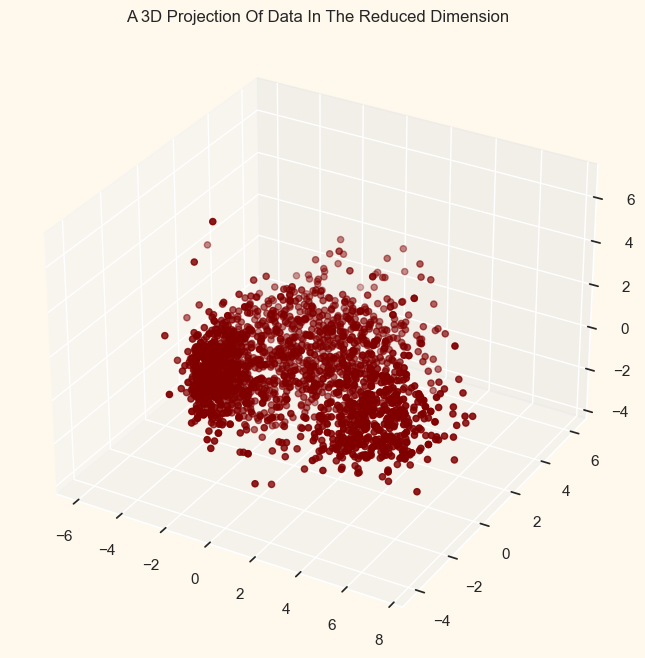

In [64]:
#a 3D Projection of data in ihe reduced dimension

x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

#to plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection of Data In The Reduced Dimension")

plt.show()

These three axes represent the three dimensions created using PCA. Each point in the 3D space corresponds to an individual customer.

This type of visualization would not be possible using all the original features, since the dataset contains many different customer characteristics. By reducing the dimensionality, we avoid the complexity of high-dimensional space.

With PCA, we effectively compress the original information into three meaningful dimensions without losing important patterns. This allows all relevant customer information to be preserved while making the data easier to visualize and interpret in a 3D space.

**The Elbow Method**

Now that all customers are plotted in three dimensions, the next step is to create clusters and group customers based on this information. Before clustering, **it is important to decide how many clusters should be created**.

There are several possible choices, such as two, three, or four clusters. The key question is how to determine the optimal number of clusters that best represents the structure of the data.

To solve this, we use a machine learning technique called the *elbow method*. The elbow method helps identify the number of clusters that provides a good balance between model simplicity and explanatory power.

This method is easier to understand when visualized. It works by plotting the clustering error against different numbers of clusters and looking for a point where the improvement starts to slow down. This point, which resembles an elbow, indicates the optimal number of clusters.

Throughout this process, many important machine learning and analytics concepts are introduced. Exploring these concepts in more depth can provide a stronger understanding of how clustering and segmentation work in practice.

Elbow Method to determine the number of clusters to be formed:


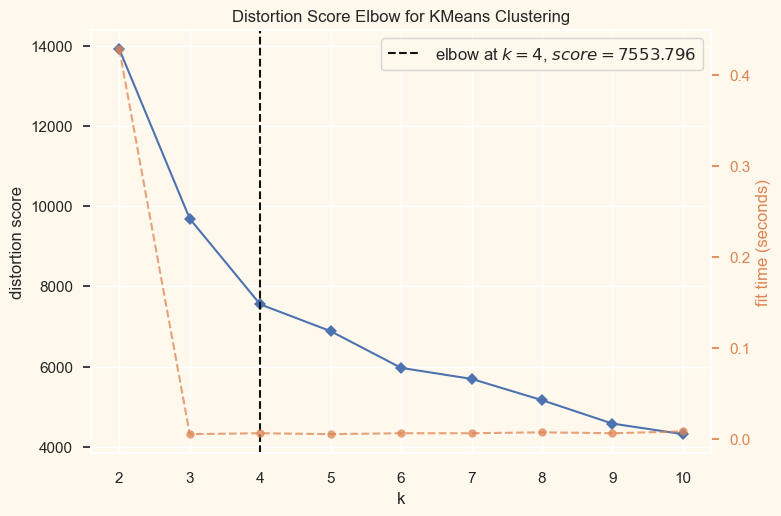

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
#quick examination of elbow method to find numbers of clusters to make

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

A blue line chart is produced that shows how the clustering error changes as the number of clusters increases.

The key idea behind the elbow method is to choose the point where the line stops decreasing sharply and begins to flatten. This point represents a good balance between reducing error and keeping the model simple.

In this case, the flattening occurs at **k = 4**, which indicates that the optimal number of clusters for this dataset is four. Beyond this point, adding more clusters does not significantly improve the clustering results. This chart provides a clear justification for selecting four customer segments based on the structure of the data.

**Applying Agglomerative Clustering**

To create the customer clusters, we use a model called *agglomerative clustering*. There are many different clustering algorithms available, but this method is well suited for this type of analysis.

Agglomerative clustering works in a bottom-up way. At the start, each data point is treated as its own individual cluster. The algorithm then measures how close clusters are to each other, usually based on the distance between points or between cluster centers.

At each step, the two closest clusters are merged together. This process is repeated until the desired number of clusters is reached. In this case, the algorithm continues merging clusters until four customer groups are formed. This approach allows natural groupings in the data to emerge based on similarity, making it effective for customer segmentation.

In [72]:
#initiating the Agglomerative Clustering model

AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

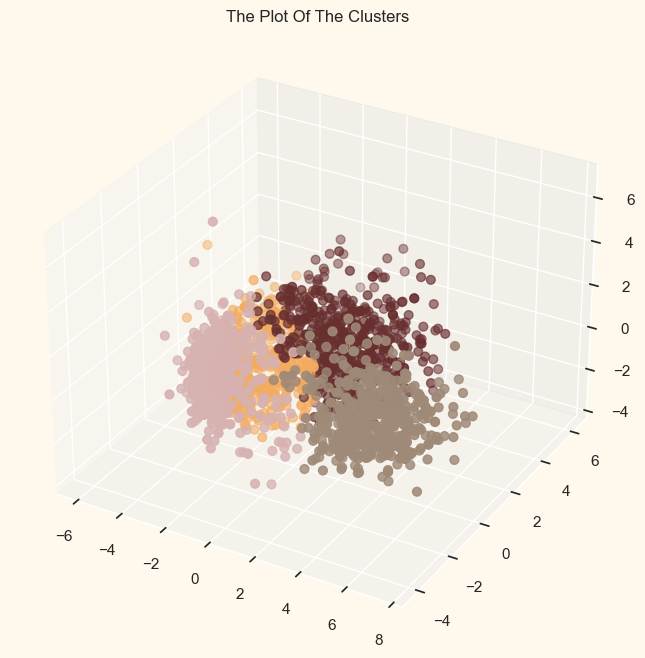

In [74]:
#plotting the clusters

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot of The Clusters")

plt.show()

**Visualizing the Final Customer Clusters**

To make the clustering results more intuitive, we plot the clusters in the three-dimensional PCA space. This visualization shows the final outcome of the clustering process.

Each point in the 3D plot represents a customer, and different colors indicate different clusters. This makes it easy to see which customers belong to which group and how the clusters are positioned relative to each other in the reduced feature space.

Since this is an unsupervised clustering algorithm, there is no accuracy score or ground truth to evaluate the model directly. Instead of measuring performance with a traditional metric, the focus shifts to understanding the structure and characteristics of the clusters. The next step is to analyze the patterns within each cluster. 

By revisiting data exploration through the lens of these clusters, meaningful insights can be extracted about customer behavior, preferences, and differences between the groups.

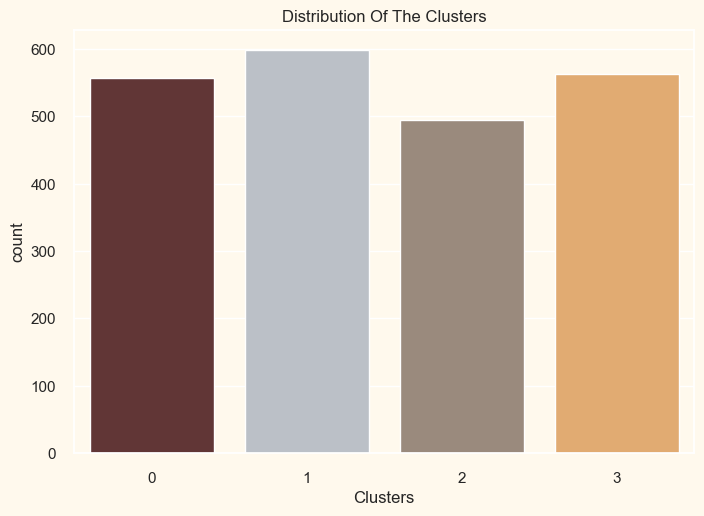

In [79]:
#plotting countplot of clusters

pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution of The Clusters")

plt.show()

First, we can look at how customers are distributed across the clusters. This is an important step because we want to make sure the clusters are fairly balanced. We want the clusters to be fairly balanced. By visualizing the number of customers in each cluster, we can quickly check whether any single group is dominating the segmentation. If one cluster has far more customers than the others, it could affect how useful and reliable our segmentation is.

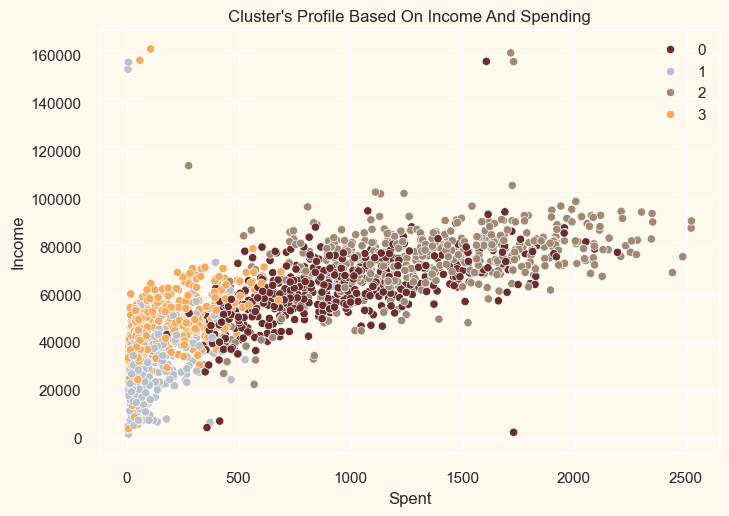

In [82]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()

plt.show()

Then we can plot different features to see how the clusters behave and how they separate from each other. For example, if we plot spending against income, we can start to interpret the characteristics of each cluster more clearly. Cluster one, shown in light blue, represents customers with low income and low spending. Cluster three also has low spending, but their income is closer to an average level. Cluster two stands out as high income and high spending customers, while cluster zero can be described as high spending with an average income level. This visualization helps us understand not just how many customers are in each cluster, but who they actually are in practical terms.

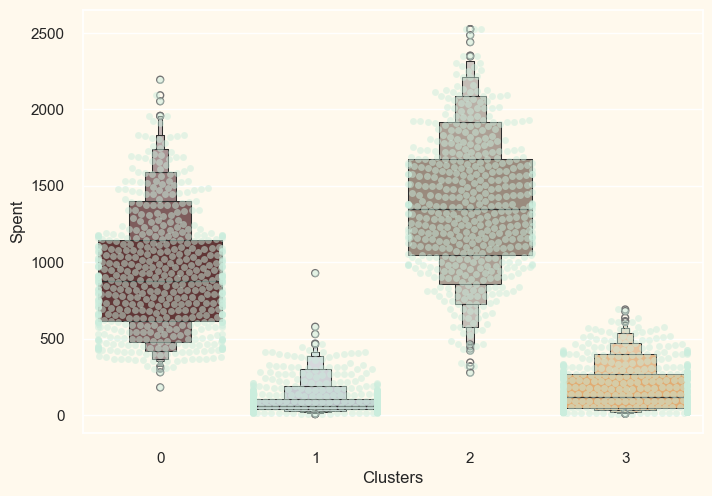

In [86]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)

plt.show()

Then we can focus only on the spending data and analyze it in more detail. This gives us another useful perspective and a different type of plot to work with. From this visualization, we can clearly see that our main customers belong to cluster two, followed by cluster zero. Clusters one and three contribute much less in comparison, especially when we look at how much they spend overall. This helps us prioritize which customer groups matter most from a revenue point of view.

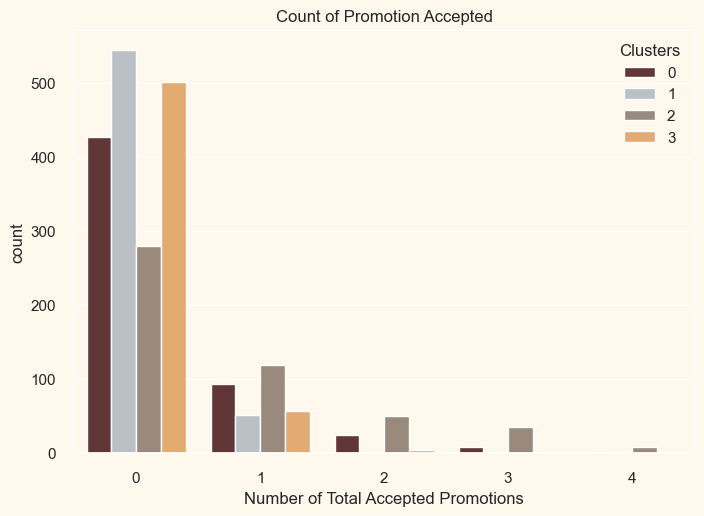

In [91]:
#creating a feature to get a sum of accepted promotions

data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]

#plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count of Promotion Accepted")
pl.set_xlabel("Number of Total Accepted Promotions")

plt.show()

We can also look at the campaign data that comes with this dataset. This allows us to understand how many promotions customers actually accepted. To do this, we create a new feature called total promos, where we sum up all the accepted campaigns across the five campaign-related columns, and then we plot the total number of promotions accepted by customers.

When we look at this chart, one thing becomes very clear. Most customers fall into the zero category, meaning they did not accept any promotions at all. This suggests that the campaigns were probably not very effective. From a business perspective, this is a strong signal for the marketing or campaign team to step back and rethink how these promotions are designed and delivered.

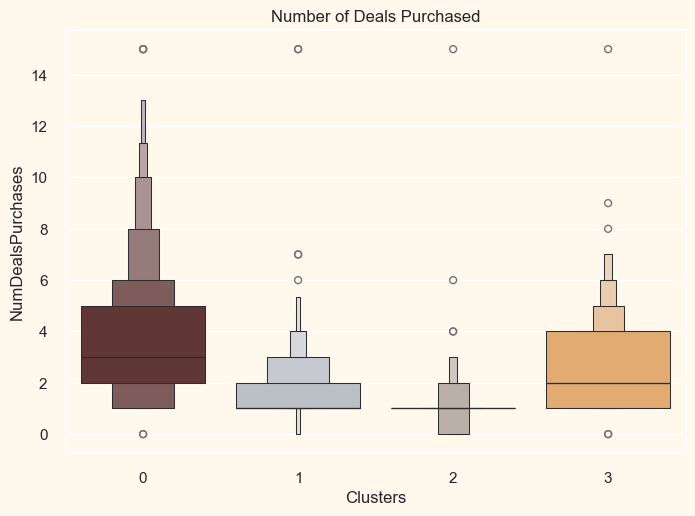

In [94]:
#plotting the number of deals purchased

plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")

plt.show()

Another useful angle is to look at how deal purchases differ across clusters. Here, we focus only on customers who have bought items through deals and compare them by cluster.

From this plot, it’s clear that cluster zero stands out. Customers in this group tend to purchase deals more frequently than the others. This is a good example of EDA becoming more powerful once clusters are in place. At this point, we can start profiling each group more precisely based on behavior and understand how different customer segments interact with the grocery shop.

And finally, I can run the last piece of code, which focuses on plotting personal customer information against spending. This step takes a few seconds to run, but it gives us a much deeper view of how different customer characteristics relate to how much they spend.

In this set of plots, the x-axis represents personal features such as number of kids at home, number of teenagers at home, customer age, and how long someone has been a customer. The y-axis shows the amount spent. By looking at these charts, we can start spotting clear patterns. For example, in the kids-at-home plot, cluster three mostly includes customers with one or two kids, while cluster two is dominated by customers with no kids at home. At the same time, we can directly compare these groups based on how much they spend.

The same type of analysis can be repeated for the other plots, such as teen count, customer age, and customer tenure. This helps us understand not just how much customers spend, but also who they are and how their personal situation connects to their purchasing behavior. These patterns are exactly what make clustering useful, because they allow us to profile customers in a much more meaningful way.

<Figure size 800x550 with 0 Axes>

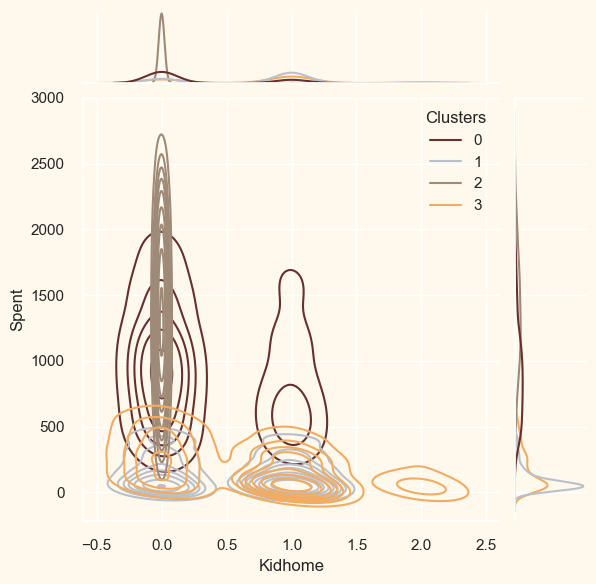

<Figure size 800x550 with 0 Axes>

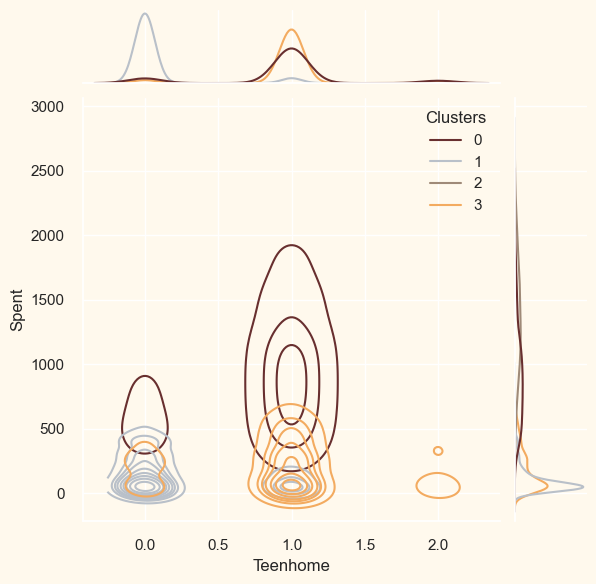

<Figure size 800x550 with 0 Axes>

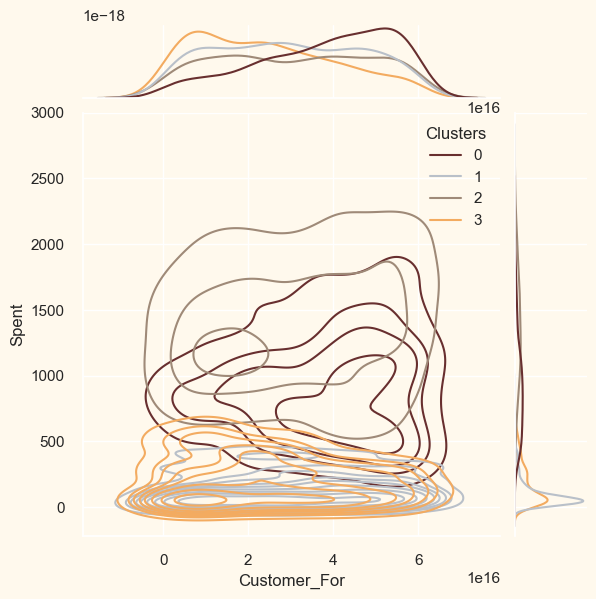

<Figure size 800x550 with 0 Axes>

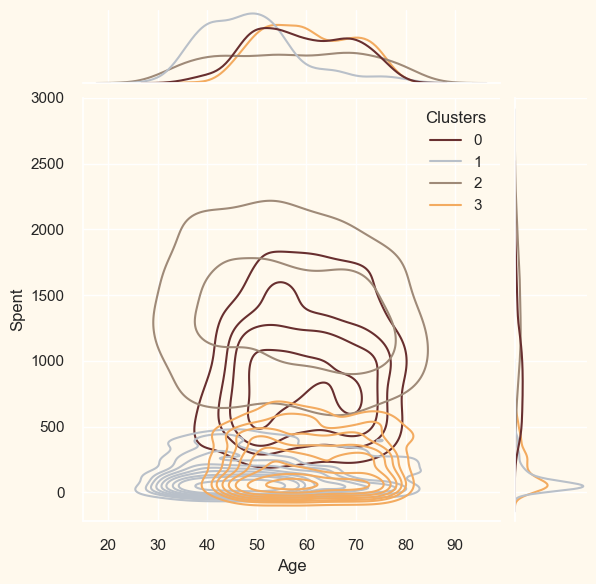

<Figure size 800x550 with 0 Axes>

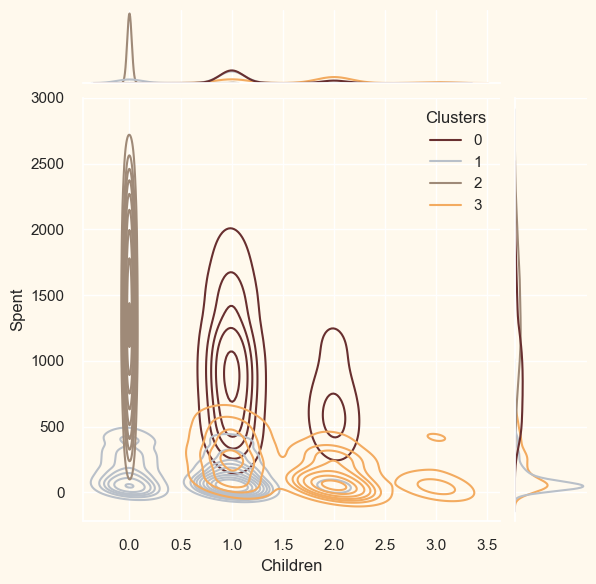

<Figure size 800x550 with 0 Axes>

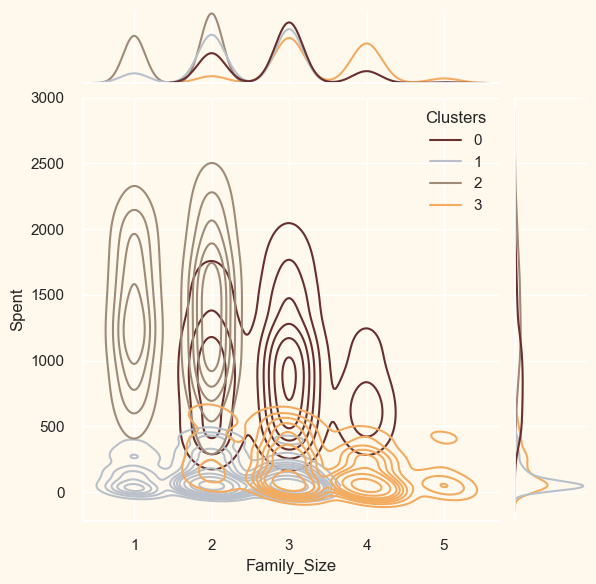

<Figure size 800x550 with 0 Axes>

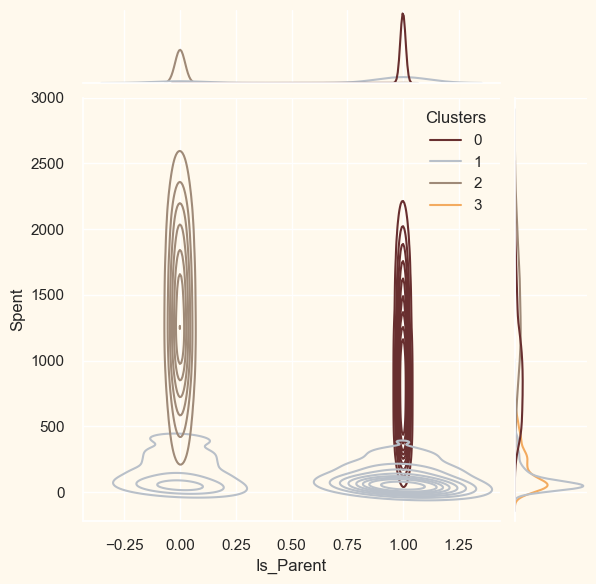

<Figure size 800x550 with 0 Axes>

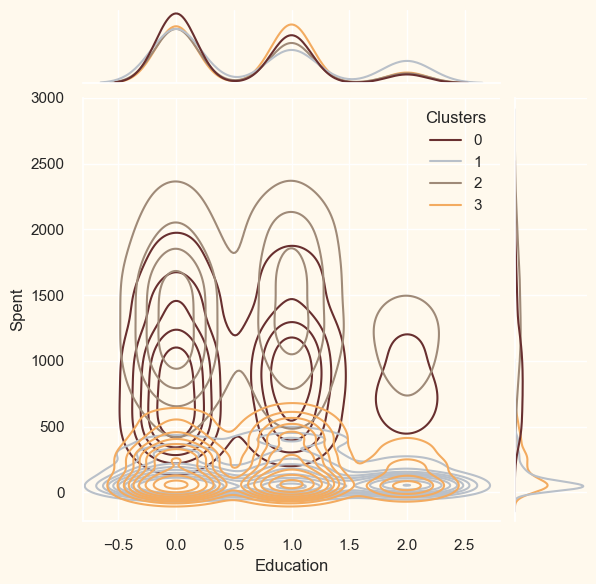

<Figure size 800x550 with 0 Axes>

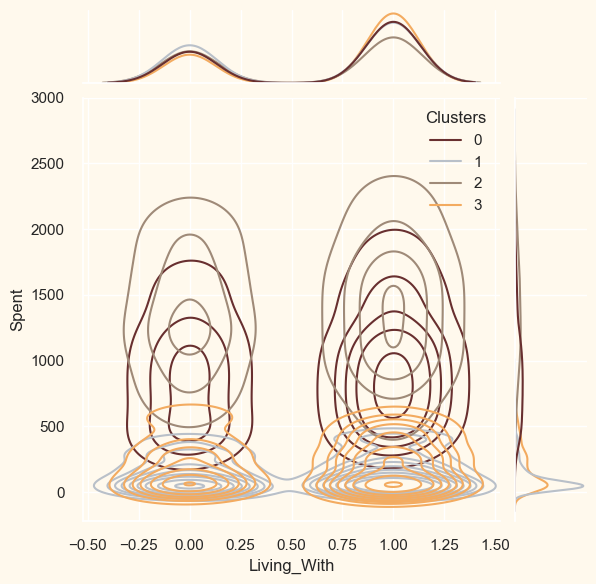

In [98]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    
    plt.show()